<a href="https://colab.research.google.com/github/Kidus-Bellete/Neural_Network-NN-/blob/main/lab03a%20NN_exercise_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/lab03a NN_exercise.zip'

In [22]:
import torch
from torch.nn import Linear, Module, CrossEntropyLoss, Dropout
from torch.nn.functional import relu, softmax
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from torch.optim import SGD
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


In [23]:
def LoadData(path):
    classes = os.listdir(path)
    images = []
    labels = []

    for c in classes:
        imageNames = os.listdir(f"{path}/{c}")
        for img in imageNames:
            images.append(cv2.imread(f"{path}/{c}/{img}", cv2.IMREAD_GRAYSCALE))
            labels.append(int(c))

    return images, labels

train_path =  '/content/digits/Train'
test_path = '/content/digits/Test'
train_images, train_labels = LoadData(train_path)
test_images, test_labels  =  LoadData(test_path)

In [24]:
train_images  = np.array(train_images)
test_images = np.array(test_images)
print(f"train images {train_images.shape}")
print(f"test_images  {test_images.shape}")

train images (10000, 28, 28)
test_images  (2000, 28, 28)


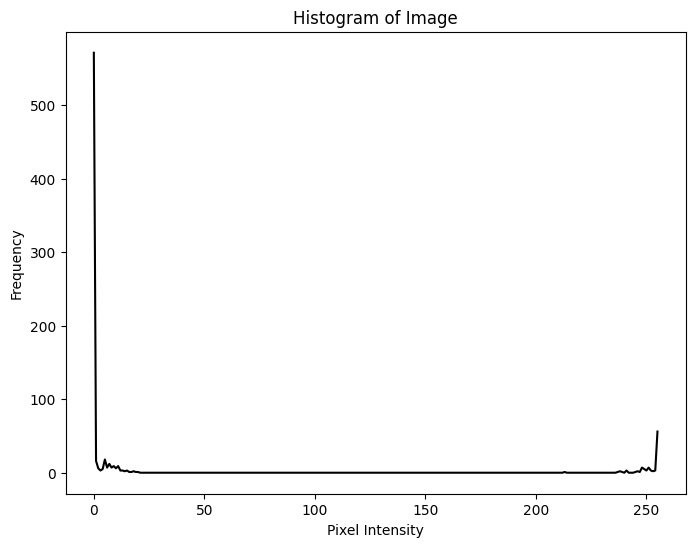

In [25]:
def plot_histogram(image):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    plt.figure(figsize=(8, 6))
    plt.plot(histogram, color='black')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram of Image')
    plt.show()

sample_images = train_images[0]
plot_histogram(sample_images)


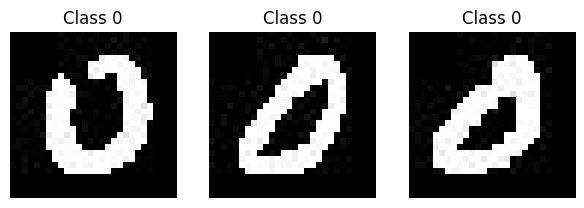

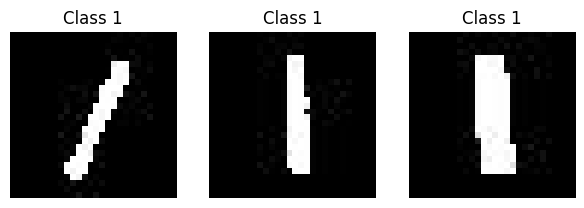

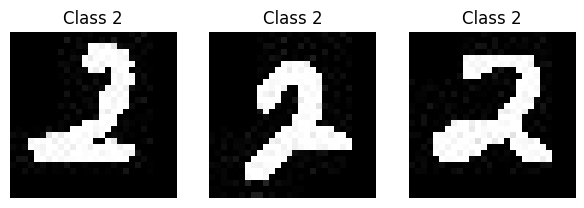

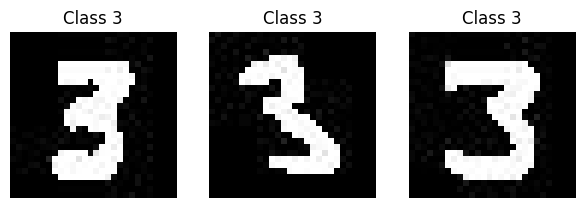

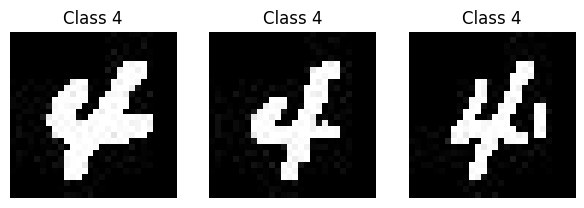

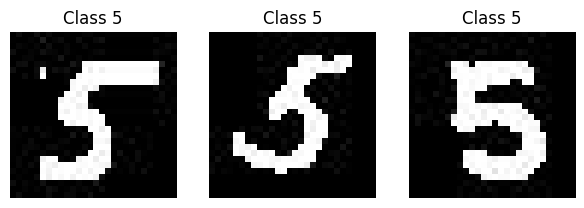

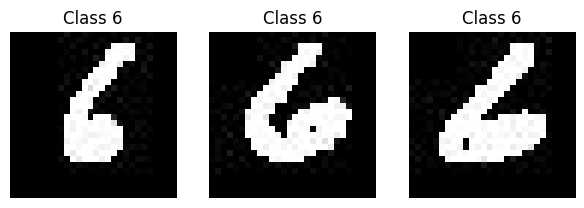

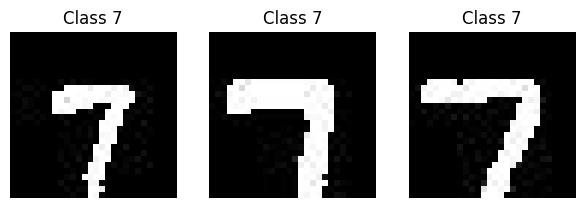

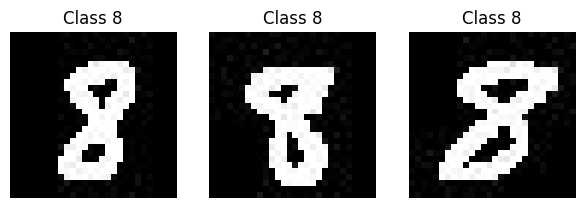

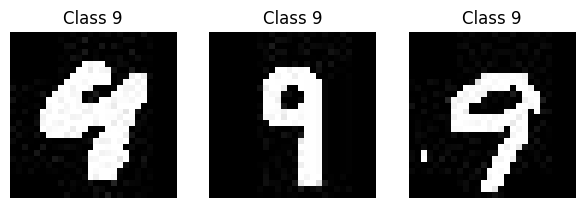

In [26]:
def display_images_per_class(images, labels):
    classes = np.unique(labels)
    num_images_per_class = 3  # Display first 3 images per class
    num_cols = 6  # Number of columns in the grid
    num_rows = -(-num_images_per_class // num_cols)  # Ceiling division to calculate the number of rows

    for c in classes:
        class_indices = np.where(labels == c)[0][:num_images_per_class]
        plt.figure(figsize=(15, 5))
        for i, index in enumerate(class_indices, 1):
            plt.subplot(num_rows, num_cols, i)
            plt.imshow(images[index], cmap='gray')
            plt.title(f"Class {c}")
            plt.axis('off')
        plt.show()

display_images_per_class(train_images, train_labels)


In [27]:
# Flatten images
train_images_flat = np.array([img.flatten() for img in train_images])
test_images_flat = np.array([img.flatten() for img in test_images])

In [28]:
train_images_split, val_images_split, train_labels_split, val_labels_split = train_test_split(train_images_flat,
                                                                                              train_labels,
                                                                                              test_size=0.2,
                                                                                              random_state=42)


In [29]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        return img, label

# Create datasets
train_dataset = CustomDataset(train_images_split, train_labels_split)
val_dataset = CustomDataset(val_images_split, val_labels_split)
test_dataset = CustomDataset(test_images_flat, test_labels)


In [60]:
#if we have added the hiden networks can the accuracy increased eg. 3 hidden layers
# changing the activation function from Relu to sigmoid or tanh can the accuracy increased
class NeuralNetwork(Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = Linear(input_size, hidden_size)
        self.fc2 = Linear(hidden_size, num_classes)
       # self.fc3 = Linear()
       # self.fc1 = Linear(input_size, hidden_size)
       # self.fc2 = Linear(hidden_size, hidden_size)
       # self.fc3 = Linear(hidden_size, hidden_size)
       # self.fc4 = Linear(hidden_size, num_classes)
    def forward(self, x):
        x = relu(self.fc1(x))
        #x = torch.sigmoid(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
       # x = torch.sigmoid(self.fc3(x))
        #x = torch.tanh(self.fc1(x))
        #x = torch.tanh(self.fc2(x))
        #x = torch.tanh(self.fc3(x))
        x = self.fc2(x)
        return x

# Initialize model
input_size = train_images_flat.shape[1]
hidden_size = 128
num_classes = len(np.unique(train_labels))
model = NeuralNetwork(input_size, hidden_size, num_classes)


In [44]:
# Define training parameters
batch_sizes = [1,32, 64, len(train_dataset)]
learning_rates = [1,0.01, 0.001, 0.0001]

# Training loop
num_epochs = 10
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

        model = NeuralNetwork(input_size, hidden_size, num_classes)
        optimizer = SGD(model.parameters(), lr=lr)
        criterion = CrossEntropyLoss()

        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images.float())
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss_history.append(train_loss / len(train_loader))
            train_acc = 100 * correct_train / total_train
            train_acc_history.append(train_acc)

            # Validation
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images.float())
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss_history.append(val_loss / len(val_loader))
            val_acc = 100 * correct_val / total_val
            val_acc_history.append(val_acc)

            print(f'Epoch [{epoch + 1}/{num_epochs}], LR: {lr}, Batch Size: {batch_size}, Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')


Epoch [1/10], LR: 1, Batch Size: 1, Train Loss: 486778.9926, Train Acc: 9.60%, Val Loss: 2.6043, Val Acc: 9.30%
Epoch [2/10], LR: 1, Batch Size: 1, Train Loss: 16220022.2561, Train Acc: 9.96%, Val Loss: 2.4467, Val Acc: 9.30%
Epoch [3/10], LR: 1, Batch Size: 1, Train Loss: 2.5426, Train Acc: 9.70%, Val Loss: 2.5399, Val Acc: 8.75%
Epoch [4/10], LR: 1, Batch Size: 1, Train Loss: 2.5417, Train Acc: 9.93%, Val Loss: 2.5487, Val Acc: 10.60%
Epoch [5/10], LR: 1, Batch Size: 1, Train Loss: 2.5376, Train Acc: 10.39%, Val Loss: 2.5216, Val Acc: 10.05%
Epoch [6/10], LR: 1, Batch Size: 1, Train Loss: 2.5471, Train Acc: 10.06%, Val Loss: 2.7257, Val Acc: 10.55%
Epoch [7/10], LR: 1, Batch Size: 1, Train Loss: 2.5413, Train Acc: 9.84%, Val Loss: 2.5087, Val Acc: 10.60%
Epoch [8/10], LR: 1, Batch Size: 1, Train Loss: 2.5406, Train Acc: 9.86%, Val Loss: 2.4143, Val Acc: 9.60%
Epoch [9/10], LR: 1, Batch Size: 1, Train Loss: 2.5434, Train Acc: 9.78%, Val Loss: 2.4486, Val Acc: 10.05%
Epoch [10/10], LR:

In [68]:
#from above observation i have seen the batch_size=32 and learning_rate=0.001 have low loss relatively therefore
# I have checked with 50 epoch now good become 94%
# Define training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 50

# Initialize model, optimizer, and loss function
model = NeuralNetwork(input_size, hidden_size, num_classes)
optimizer = SGD(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()

# Training loop
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_history.append(train_loss / len(train_loader))
    train_acc = 100 * correct_train / total_train
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_history.append(val_loss / len(val_loader))
    val_acc = 100 * correct_val / total_val
    val_acc_history.append(val_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}], LR: {learning_rate}, Batch Size: {batch_size}, Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')


Epoch [1/50], LR: 0.001, Batch Size: 64, Train Loss: 4.1128, Train Acc: 65.31%, Val Loss: 0.7127, Val Acc: 78.20%
Epoch [2/50], LR: 0.001, Batch Size: 64, Train Loss: 0.5364, Train Acc: 83.59%, Val Loss: 0.5644, Val Acc: 82.35%
Epoch [3/50], LR: 0.001, Batch Size: 64, Train Loss: 0.3996, Train Acc: 87.69%, Val Loss: 0.5117, Val Acc: 85.90%
Epoch [4/50], LR: 0.001, Batch Size: 64, Train Loss: 0.3243, Train Acc: 90.24%, Val Loss: 0.4592, Val Acc: 87.00%
Epoch [5/50], LR: 0.001, Batch Size: 64, Train Loss: 0.2762, Train Acc: 91.61%, Val Loss: 0.4409, Val Acc: 87.35%
Epoch [6/50], LR: 0.001, Batch Size: 64, Train Loss: 0.2378, Train Acc: 92.54%, Val Loss: 0.4248, Val Acc: 88.00%
Epoch [7/50], LR: 0.001, Batch Size: 64, Train Loss: 0.2102, Train Acc: 93.58%, Val Loss: 0.4388, Val Acc: 88.15%
Epoch [8/50], LR: 0.001, Batch Size: 64, Train Loss: 0.1856, Train Acc: 94.17%, Val Loss: 0.4159, Val Acc: 88.65%
Epoch [9/50], LR: 0.001, Batch Size: 64, Train Loss: 0.1615, Train Acc: 95.17%, Val Loss

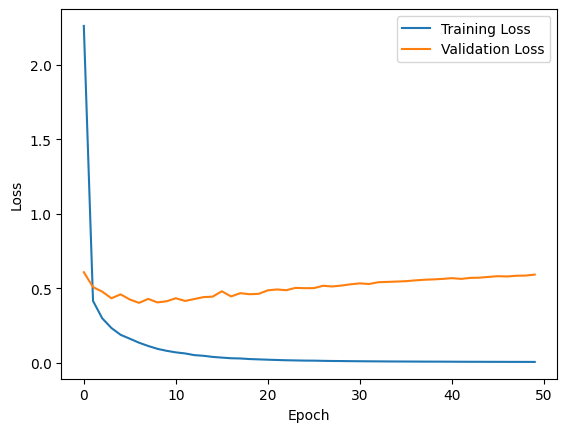

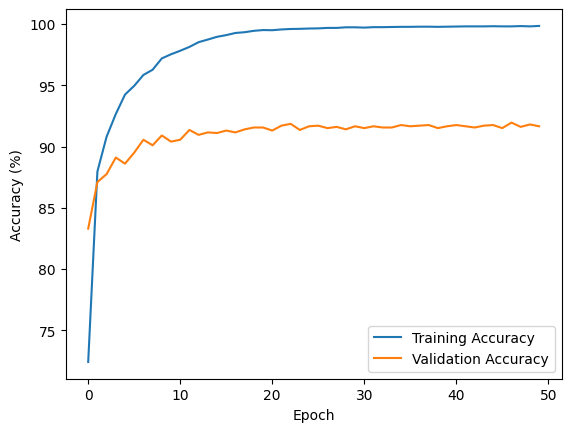

In [62]:
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [69]:
# the accuracy is very low as I mentioned from above the nn model modification can we increase the accuracy result here
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

# Testing
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Testing Accuracy: {test_accuracy:.2f}%')


Testing Accuracy: 92.60%


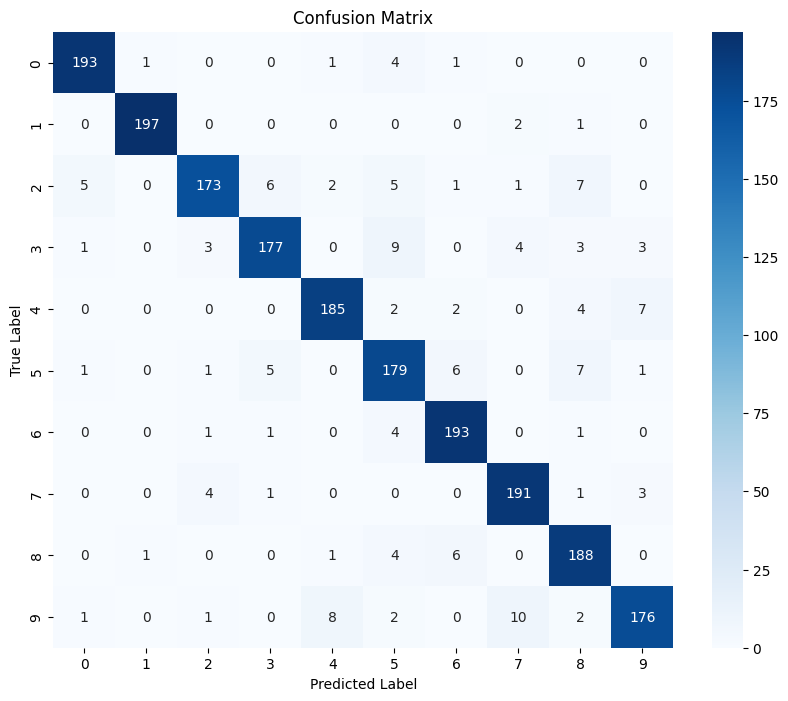

In [70]:
# Get predictions for the entire test set
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.float())
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
